# K-Nearest Neighbor Lab





In [122]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [118]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', k=3, normalize=False, regression=False):
        self.columntype = columntype 
        self.weight_type = weight_type
        self.k = k
        self.normalize = normalize
        self.regression = regression

    def fit(self, X, y):
        if self.normalize:
            X = self.normalize_X(X)
        self.trained_X = X
        self.trained_y = y
        return self
    
    def predict(self, X):
        prediction = np.array([])
        for row in X:
            prediction = np.append(prediction, self.calculateNearestNeighbor(row))
        return prediction, prediction.shape[0]
        
    def calculateNearestNeighbor(self, data_row):
        if len(self.columntype) == 0:
            distances = np.linalg.norm(self.trained_X - data_row, axis=1)
        else:
            trained_copy = np.copy(self.trained_X)
            for x,y in np.ndindex(trained_copy.shape):
                    if self.columntype[y] == "nominal":
                        if trained_copy[x,y] == data_row[y]:
                            trained_copy[x,y] = 0
                        else:
                            trained_copy[x,y] = 1
            for x in range(len(data_row)):
                if self.columntype[x] == "nominal":
                    data_row[x] = 0
            distances = np.linalg.norm(trained_copy.astype(np.float64) - data_row.astype(np.float64), axis=1)
        distances = np.array((distances, self.trained_y)).T.astype(str)
        distances = distances[distances[:,0].astype(float).argsort()]
        neighbors = distances[:self.k]
        if self.regression:
            if self.weight_type == 'no_weight':
                winner = np.average(neighbors[:,1].astype(float))
            else:
                weights = np.array([])
                winner = 0
                numerator = 0
                for row in neighbors:
                    if(float(row[0]) > 0):
                        weights = np.append(weights, 1/float(row[0])**2)
                    else:
                        weights = np.append(weights, 0.0)
                denominator = np.sum(weights)
                for i in range(len(neighbors)):
                    numerator += neighbors[i,1].astype(float)/(neighbors[i,0].astype(float)**2)
                winner = numerator/denominator
        elif self.weight_type == 'no_weight':
            values, counts = np.unique(neighbors[:,1], return_counts=True)
            winner = values[np.argmax(counts)]
        else:
            weights = np.array([])
            for row in neighbors:
                if(float(row[0]) > 0):
                    weights = np.append(weights, 1/float(row[0])**2)
                else:
                    weights = np.append(weights, 0.0)
            values = neighbors[:,1]
            unique_values = np.unique(values)
            added_weights = np.zeros(len(unique_values))
            for i in range(len(weights)):
                added_indx = np.where(unique_values==values[i])
                added_weights[added_indx] += weights[i]
            winner = unique_values[np.argmax(added_weights)]
        return winner
        
    def score(self, X, y, k=3):
        self.k = k
        if self.normalize:
            X = self.normalize_X(X)
        prediction, length = self.predict(X)
        if self.regression:
            return np.square(np.subtract(y,prediction)).mean() 
        else:
            correct = 0
            for i in range(length):
                if prediction[i] == y[i]:
                    correct += 1
            return correct/length
    
    def normalize_X(self, X):
        index = 0
        for col in X.T:
            X[:,index] = (col - col.min()) / (col.max() - col.min())
            index += 1
        return X
    
    def fill_unknown_values(self, X):
        index = 0
        for col in X.T:
            if self.columntype[index] == "nominal":
                values, counts = np.unique(col, return_counts=True)
                mean = values[np.argmax(counts)]
                nan_indexes = np.where(col == "?")
            else:
                mean = np.nanmean(col.astype(np.float64))
                nan_indexes = np.where(np.isnan(col.astype(np.float64)))
            for i in nan_indexes[0]:
                col[i] = mean
            index += 1
        return X

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

Debug your model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Acc = [93.57]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/seismic-bump-prediction.csv)


In [175]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['Class'] = df['Class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier().fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['Class'] = df['Class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn.score(X,y)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  26196      0 --:--:-- --:--:-- --:--:-- 26196
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9597  100  9597    0     0  28733      0 --:--:-- --:--:-- --:--:-- 28647


0.9357142857142857

### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [176]:
# Load diabetes data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier().fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn.score(X,y)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37419  100 37419    0     0   110k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73698  100 73698    0     0   186k      0 --:--:-- --:--:-- --:--:--  186k


0.890625

## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [281]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(weight_type='no_weight').fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn.score(X,y)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  1978k      0 --:--:-- --:--:-- --:--:-- 1978k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  1377k      0 --:--:-- --:--:-- --:--:-- 1377k


0.8082808280828083

### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [282]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(normalize=True, weight_type='no_weight').fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn.score(X,y)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  3648k      0 --:--:-- --:--:-- --:--:-- 3648k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0   963k      0 --:--:-- --:--:-- --:--:--  963k


0.8157815781578158

I got about a 1% accuracy increase by normalizing the data, from 80.82% to 81.58% accuracy. 

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  1769k      0 --:--:-- --:--:-- --:--:-- 1765k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  1327k      0 --:--:-- --:--:-- --:--:-- 1327k


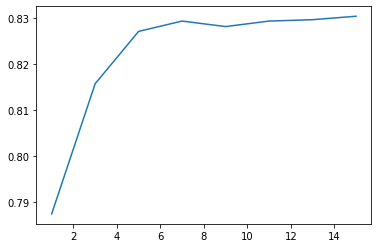

In [5]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(normalize=True, weight_type='no_weight').fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))

accuracy_values = np.array([])
k_values = np.array([])
for i in range(1,16,2):
    k_values = np.append(k_values, i)
    accuracy_values = np.append(accuracy_values,knn.score(X,y,k=i))
plt.plot(k_values, accuracy_values)
plt.show()


# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  10471      0 --:--:-- --:--:-- --:--:-- 10443


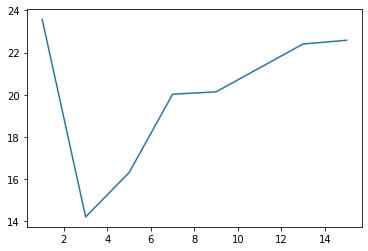

In [4]:
# Load housing price prediction data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(normalize=True, regression=True, weight_type='no_weight').fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn.score(X,y,k=7)
# Train/Predict using k=1,3,...,15

accuracy_values = np.array([])
k_values = np.array([])
for i in range(1,16,2):
    k_values = np.append(k_values, i)
    accuracy_values = np.append(accuracy_values,knn.score(X,y,k=i))
plt.plot(k_values, accuracy_values)
plt.show()
# Graph MSE over k


## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  1636k      0 --:--:-- --:--:-- --:--:-- 1633k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0   857k      0 --:--:-- --:--:-- --:--:--  855k


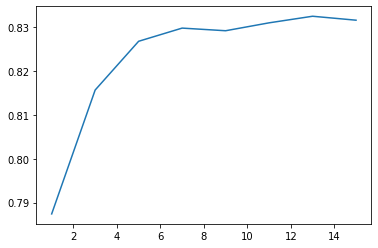

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   118k      0 --:--:-- --:--:-- --:--:--  118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  10732      0 --:--:-- --:--:-- --:--:-- 10732


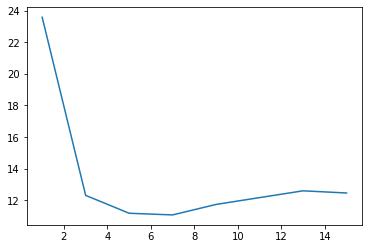

In [26]:
# Train/Predict magic telescope using distance-weighted voting
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(normalize=True).fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))

accuracy_values = np.array([])
k_values = np.array([])
for i in range(1,16,2):
    k_values = np.append(k_values, i)
    accuracy_values = np.append(accuracy_values,knn.score(X,y,k=i))
plt.plot(k_values, accuracy_values)
plt.show()

# Train/Predict housing using distance-weighted voting
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(normalize=True, regression=True).fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))

accuracy_values = np.array([])
k_values = np.array([])
for i in range(1,16,2):
    k_values = np.append(k_values, i)
    accuracy_values = np.append(accuracy_values,knn.score(X,y,k=i))
plt.plot(k_values, accuracy_values)
plt.show()


For the magic telescope dataset, using normalized data and distance weighting increased the accuracy by up to 1%, but as the number of neighbors increased, the difference in accuracy was minimal.

For the housing dataset, normalizing the data led to a lower MSE overall, and the MSE stayed low as the number of neighbors increased, whereas the MSE increased when using no weighting after the number of neighbors were greater than 3.

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [121]:
# Load dataset and split into train/test sets
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])

# Decode bytes and normalize floats
for column_name, column_data in df.iteritems():
    if column_data.dtype == object:
        df[column_name] = df[column_name].apply(lambda x: x.decode('utf-8'))
    else:
        df[column_name] =(df[column_name]-df[column_name].min())/(df[column_name].max()-df[column_name].min())
        
column_types = ["nominal", "real", "real", "nominal", "nominal",
               "nominal", "nominal", "real",  "nominal", "nominal",
              "real",  "nominal",  "nominal", "real", "real"]
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))

knn = KNNClassifier(columntype=column_types)
# Fill unknown ? values with the averages of each column 
X = knn.fill_unknown_values(X)

#Split test and train
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3)

#Fit and score
knn.fit(X_train,y_train)
knn.score(X_test, y_test)




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34315  100 34315    0     0   328k      0 --:--:-- --:--:-- --:--:--  328k


0.8454106280193237

This is how I handle different types of values:

Unknown: Before I fit, I use my KNN to fill in unknown values for each column by using the average value of that column (for continuous data) or using the most common value for that column (for nominal data)

Continuous: I use euclidian distance

Nominal: When I test the distance from the data to the row of test data, I mark equivalent values as a distance of zero away, and non-equivalent values as a distance of one away. This way there is no distance to the same value and the same distance to every other value.

I used k=3 to get the above result.

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [174]:
# Train/Predict magic telescope using scikit's KNN
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
knn = KNNClassifier(columntype=column_types)
X = knn.normalize_X(X)

neigh = KNeighborsClassifier(n_neighbors=13, weights='distance')
neigh.fit(X, y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
X = knn.normalize_X(X)
print("Magic telescope score:", neigh.score(X, y))

# Train/Predict housing using scikit's KNN

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
X = knn.normalize_X(X)

neigh = KNeighborsRegressor(n_neighbors=3, weights='distance')
neigh.fit(X, y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.squeeze(np.reshape(np_data[:,-1], (-1, 1)))
X = knn.normalize_X(X)

print("Housing score:", neigh.score(X, y))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  3459k      0 --:--:-- --:--:-- --:--:-- 3459k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  2633k      0 --:--:-- --:--:-- --:--:-- 2647k
Magic telescope score: 0.8301830183018302
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0      0      0 --:--:-- --:--:-- --:--:--     0   0   347k      0 --:--:-- --:--:-- --:--:--  347k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  42692

I was able to get the bestaccuracy with the scikit KNN (83%) on magic telescope with k=13, distance weighting and normalized data, which is comparable to my own magic telescope testing with the same parameters.

I was able to get a .83 K^2 score with the scikit KNN Regressor with k=3, distance weighting and normalized data. I'm not sure how it compares to my best MSE for housing, which was about 11 with k=7, distance weighting and normalized data.

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
